## Projet Big Data : Fast and Scalable Connected Component Computation in MapReduce

* Min HUANG
* Mounia ZRIGUI
* Mohamed KOUHOU

In [6]:
from pyspark import SparkConf
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [7]:
L = [[1, 2], [2, 3], [2, 4], [4, 5], [6, 7], [7, 8]]
r = sc.parallelize(L)
r.collect()

[[1, 2], [2, 3], [2, 4], [4, 5], [6, 7], [7, 8]]

In [ ]:
# MAP
def map_ccf(r):
  r1 = r.map(lambda x:(int(x[1]),int(x[0])))
  return r.union(r1)

In [ ]:
# CCF-Iterate-Reduce
def reduce_ccf_iterate(r_map):
    # Chercher la valeur minimale
    v_min_1 = r_map.reduceByKey(lambda x,y:min(x,y))
    v_min = v_min_1.map(lambda x: (x[0],x[0]) if x[0]<x[1] else (x[0],x[1])).partitionBy(100).cache()
    # Premier emit : if(min < key) => emit(key, min)
    emit_1 = v_min.filter(lambda x: x[0]>x[1])

    # Deuxième emit : if(min != value) => emit(value, min)
    min_value = r_map.join(v_min).filter(lambda x:x[0]>x[1][1]).filter(lambda x: x[1][0] != x[1][1])
    NewPair = min_value.count()
    emit_2 = min_value.map(lambda x:(x[1][0],x[1][1]))
    return NewPair,emit_1.union(emit_2)


In [ ]:
r_map = map_ccf(r)
# newPair, r_reduce = reduce_ccf_iterate(r_map)
# r_reduce.collect()

In [ ]:
# CCF-Iterate (w. secondary sorting)
def cff_second_iterate(r_map):

  # List de valeurs triée et emit minV alue < key
  min_key = r_map.groupByKey().mapValues(list).map(lambda x: (x[0],sorted(x[1]))).filter(lambda x:x[0]>x[1][0]).partitionBy(100).cache()
  min_key_emit = min_key.map(lambda x:(x[0],x[1][0]))
  # Emit les tuple (value, minV alue)
  value_min_emit = min_key.flatMap(lambda x: [(value, x[1][0]) for value in x[1][1:]])

  # Count the new pair
  newPair = value_min_emit.count()
  return newPair, min_key_emit.union(value_min_emit)

In [ ]:
newPair, cff_r = cff_second_iterate(r_map)
cff_r.collect()

Out[15]: [(2, 1),
 (3, 2),
 (4, 2),
 (5, 4),
 (7, 6),
 (8, 7),
 (3, 1),
 (4, 1),
 (5, 2),
 (8, 6)]

In [ ]:
# Etape CCF_Dedup
def CCF_Dedup(cff_r):
  map_r_cff = cff_r.map(lambda x : ((x[0],x[1]),0))
  dedup = map_r_cff.reduceByKey(lambda x,y:x+y).map(lambda x: (x[0][0],x[0][1]))
  return dedup

In [ ]:
CCF_Dedup(cff_r).collect()

Out[16]: [(8, 6),
 (8, 7),
 (2, 1),
 (3, 1),
 (3, 2),
 (5, 4),
 (4, 1),
 (5, 2),
 (4, 2),
 (7, 6)]

In [ ]:
import time
def combine_iterate_1(r):
    newPair = 1
    newPairs = []
    i = 0
    iters = []
    T_start = time.time()
    iters_times = []
    while newPair > 0:
        T_start_iter = time.time()
        r_map = map_ccf(r)
        newPair, r_reduce = reduce_ccf_iterate(r_map)
        r = CCF_Dedup(r_reduce)
        T_end_iter = time.time()
        iter_time = T_end_iter - T_start_iter
        iters_times.append(iter_time)
        newPairs.append(newPair)
        iters.append(i)
        i = i+1
        print('iterate: %d, newPair: %d, Iteration time: %s s' %((i,newPair,iter_time)))
    else :
        T_end = time.time()
        print('Total execute time:%s s' % ((T_end - T_start)))
        return iters_times, iters, newPairs, r

In [ ]:
import time
def combine_iterate_2(r):
    NewPair = 1
    i = 0
    NewPair_list = []
    iterat_list = []
    T = []
    T1 = time.time()
    while NewPair > 0:
        r_map = map_ccf(r)
        NewPair, r_reduce = cff_second_iterate(r_map)
        r = CCF_Dedup(r_reduce)
        T2 = time.time()
        T.append(T2 - T1)
        iterat_list.append(i)
        NewPair_list.append(NewPair)
        i = i+1
        print('Execute time:%s s' % ((T2 - T1)))
        print('iterate : %d,NewPair : %d' %((i,NewPair)))
    else :
        T2 = time.time()
        print('Total execute time:%s s' % ((T2 - T1)))
        return T,iterat_list,NewPair_list,r

In [ ]:
iterat_list,NewPair_list,r = combine_iterate_2(r)
# r.collect(),iterat_list,NewPair_list

Execute time:1.1826796531677246 s
iterate : 1,NewPair : 4
Execute time:10.065488815307617 s
iterate : 2,NewPair : 9
Execute time:18.912254571914673 s
iterate : 3,NewPair : 4
Execute time:27.84720015525818 s
iterate : 4,NewPair : 0
Total execute time:27.847314596176147 s


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-3884738723935462> in <cell line: 1>()
----> 1 iterat_list,NewPair_list,r = combine_iterate_2(r)
      2 # r.collect(),iterat_list,NewPair_list

ValueError: too many values to unpack (expected 3)

In [ ]:
# Data Load, Data clean
rdd_txt = sc.textFile('/FileStore/tables/web_Google.txt').map(lambda x: x.split('\t')).\
  filter(lambda x: not x[0].startswith('#')).map(lambda x: (int(x[0]),int(x[1])))

In [ ]:
iters_times, iters, newPairs, r = combine_iterate_1(r)
# r_map.collect()

iterate: 1, newPair: 4, Iteration time: 2.499788999557495 s
iterate: 2, newPair: 9, Iteration time: 18.06307888031006 s
iterate: 3, newPair: 4, Iteration time: 49.003862142562866 s
iterate: 4, newPair: 0, Iteration time: 111.51815938949585 s
Total execute time:181.08543372154236 s


In [ ]:
iters_times, iters, newPairs, r = combine_iterate_1(rdd_txt)

iterate: 1, newPair: 8552232, Iteration time: 51.71148943901062 s
iterate: 2, newPair: 4758451, Iteration time: 71.72819185256958 s
iterate: 3, newPair: 3278772, Iteration time: 148.0484266281128 s
iterate: 4, newPair: 3888454, Iteration time: 307.09818840026855 s
iterate: 5, newPair: 1905323, Iteration time: 441.1291308403015 s
iterate: 6, newPair: 86783, Iteration time: 655.3581163883209 s
iterate: 7, newPair: 1318, Iteration time: 1286.682455778122 s
iterate: 8, newPair: 0, Iteration time: 2729.0079452991486 s
Total execute time:5690.764791250229 s


Out[10]: Text(0.5, 0, 'itération')

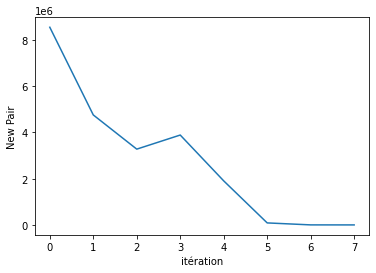

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iters,newPairs)
# plt.plot(iterat_list,t)
plt.ylabel("New Pair")
plt.xlabel("itération")

Out[11]: Text(0.5, 0, 'itération')

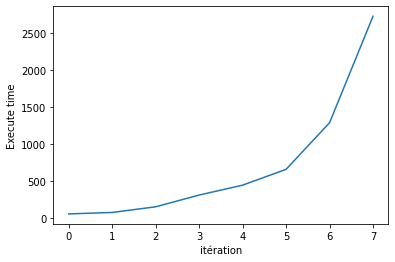

In [ ]:
plt.plot(iters,iters_times)
plt.ylabel("Execute time")
plt.xlabel("itération")

In [ ]:
t,iterat_list,NewPair_list,r = combine_iterate_2(rdd_txt)
# r.collect(),iterat_list,NewPair_list

Execute time:17.928903102874756 s
iterate : 1,NewPair : 8670951
Execute time:58.91169500350952 s
iterate : 2,NewPair : 4821525
Execute time:90.40827655792236 s
iterate : 3,NewPair : 3278772
Execute time:119.11889243125916 s
iterate : 4,NewPair : 3888454
Execute time:146.97083687782288 s
iterate : 5,NewPair : 1905323
Execute time:168.49880981445312 s
iterate : 6,NewPair : 86783
Execute time:185.89400148391724 s
iterate : 7,NewPair : 1318
Execute time:200.58122992515564 s
iterate : 8,NewPair : 0
Total execute time:200.58132338523865 s


In [ ]:
t

Out[21]: [17.928903102874756,
 58.91169500350952,
 90.40827655792236,
 119.11889243125916,
 146.97083687782288,
 168.49880981445312,
 185.89400148391724,
 200.58122992515564]

Out[22]: Text(0.5, 0, 'itération')

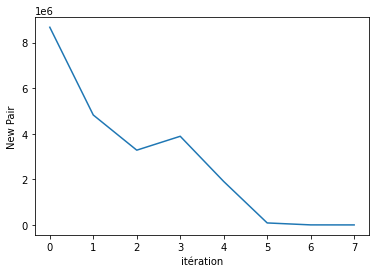

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iterat_list,NewPair_list)
# plt.plot(iterat_list,t)
plt.ylabel("New Pair")
plt.xlabel("itération")

Out[23]: Text(0.5, 0, 'itération')

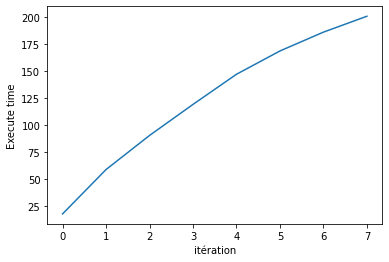

In [ ]:
plt.plot(iterat_list,t)
plt.ylabel("Execute time")
plt.xlabel("itération")

In [1]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import matplotlib.pyplot as plt


In [8]:
G = nx.Graph()
color_map = []
graph_edges = r.collect()
clusters = r.map(lambda x : x[1]).distinct().collect()
for edge in graph_edges:
  G.add_edge(edge[0],edge[1])
for node in G:
  if node in clusters:
    color_map.append('green')
  else:
    color_map.append('red')

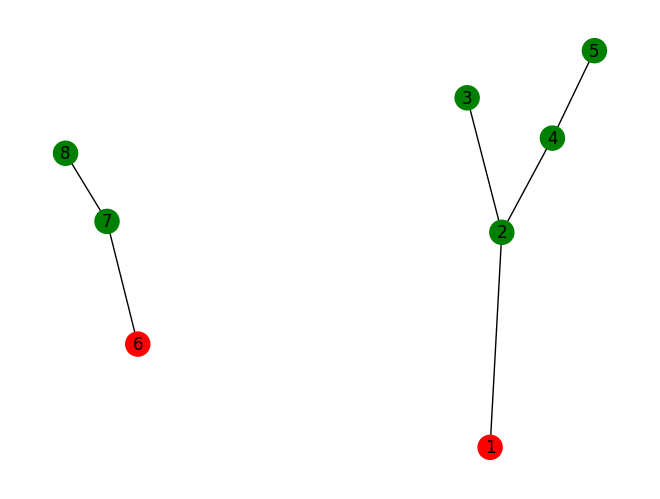

In [12]:
nx.draw(G,node_color=color_map, with_labels=True)
plt.show()